# Assignment 1 2AMM10 2023-2024

## Group: 15
### Member 1: Siebe Deerenberg
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import BatchSampler
from torchvision import datasets, transforms
from itertools import combinations
from scipy.spatial.distance import cdist



# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

c:\Users\20203641\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Download data with kagglehub

In [3]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [4]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [5]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


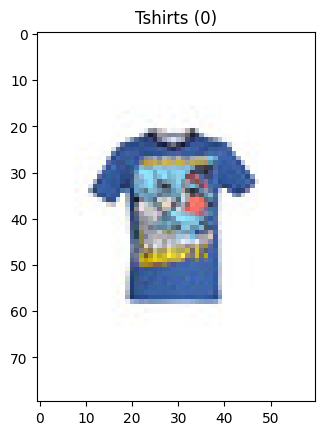

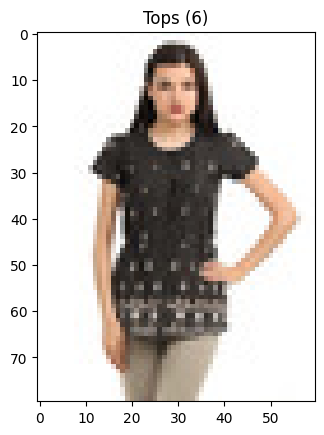

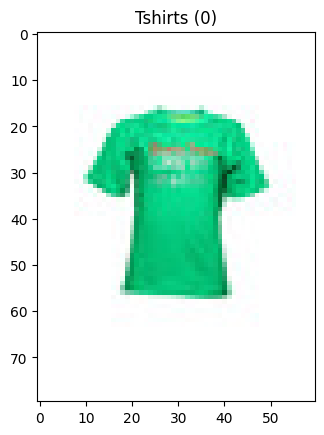

In [6]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [7]:
transform = transforms.Compose([
    transforms.Resize((80, 80)), #resize to 80x80, because the original images have different sizes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)}
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

### Model Architecture

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes, bw = 32, lr= 0.001):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3,  bw,  kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),

            nn.Conv2d(bw, bw, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),

            nn.Conv2d(bw*2, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw*2, bw*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*4),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p = 0.3),
            nn.Linear(bw*4, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Helper Functions

In [10]:
#import with data loaders
def get_data(train_ds, valid_ds, test_ds, batch_size=64):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_dl, valid_dl, test_dl

def loss_batch(model, loss_func, xb, yb, opt=None):

    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.data)


    return loss.item(), corrects, len(xb), preds, yb


def fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl):
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    train_accs = []
    val_accs = []

    for epoch in tqdm(range(epochs)):


        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:

            # move data to GPU if available
            xb = xb.to(device)
            yb = yb.to(device)

            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums, *_ = loss_batch(model, loss_func, xb, yb,opt)

            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num
        train_accs.append(train_acc)


        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0

            all_preds, all_trues = [], []

            for xb, yb in valid_dl:

                xb = xb.to(device)
                yb = yb.to(device)


                # forward
                losses, corrects, nums, preds, yb = loss_batch(model, loss_func, xb, yb)

                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

                all_preds.append(preds.cpu())
                all_trues.append(yb.cpu())



            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            bacc = balanced_accuracy_score(torch.cat(all_trues), torch.cat(all_preds))

            val_accs.append(val_acc)

            scheduler.step(val_loss) # decrease the learning rate if validation loss increases


        # print the results
        print(
            f'EPOCH with LR {scheduler.get_last_lr()[0]}: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ', f"VAL-BACC: {bacc:.4f} ",end='\n')

        if val_acc >= 0.80 and bacc >= 0.8:
          print("Early Stopping")
          break

    plot_train(train_accs, val_accs)

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Prepare data

In [11]:
# Split the main_test_dataset
valid_size = int(0.8 * len(main_test_dataset))
holdout_size = len(main_test_dataset) - valid_size
valid_dataset, holdout_dataset = random_split(main_test_dataset, [valid_size, holdout_size])

train_dl, valid_dl, holdout_dl = get_data(train_dataset, valid_dataset, holdout_dataset,batch_size=526) # you have to decrease batch size for lower RAM gpus/cpus


### Training the model

In [ ]:
epochs=100
lr = 0.1

model = CNN(num_classes=39)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3) # decrease the learning rate if validation loss increases
loss_func = F.cross_entropy



fit(epochs, model, loss_func, opt, scheduler, train_dl, valid_dl)

torch.save(model.state_dict(), 'models/fashion_model_weights.pth')

### Evaluate on Test Set

In [12]:

def evaluate_model(model, holdout_dl):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():  # No gradients needed for evaluation
        for x, y in holdout_dl:
            if torch.cuda.is_available():
                x, y = x.cuda(), y.cuda()

            outputs = model(x)
            _, preds = torch.max(outputs, 1)

            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Calculate metrics
    accuracy = total_correct / total_samples
    balanced_acc = balanced_accuracy_score(all_targets, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    return accuracy, balanced_acc

# model and weights
model = CNN(num_classes=39)  # Initialize with the same architecture
model.load_state_dict(torch.load('models/fashion_model_weights.pth', map_location=device))

if torch.cuda.is_available():
    model = model.cuda()

# 3. Evaluate on the new test dataset
accuracy, balanced_accuracy = evaluate_model(model, holdout_dl)

Test Accuracy: 0.8750
Balanced Accuracy: 0.7910


## Task 2

### Model Architecture

In [9]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    def __init__(self, bw = 32, lr= 0.001, embedding_dim=39):
        """CNN Builder."""
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            nn.Conv2d(3,  bw,  kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),

            nn.Conv2d(bw, bw, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),

            nn.Conv2d(bw*2, bw*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*2),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(bw*2, bw*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(bw*4),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )

        self.embedding_layer = nn.Linear(bw*4, embedding_dim)

    def forward(self, x):
        features = self.front_layer(x)
        embedding = self.embedding_layer(features)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding

    def get_embedding(self, x):
        return self.forward(x)


### Helper Functions

In [10]:
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

# initialize Batch Sampler
train_batch_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=39, n_samples=8)
test_batch_sampler = BalancedBatchSampler(main_test_dataset.targets, n_classes=39, n_samples=8)

# initialize DataLoader
triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_test_loader = torch.utils.data.DataLoader(main_test_dataset, batch_sampler=test_batch_sampler)

from itertools import combinations
def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix
class Informative_Negative_TripletSelector():

    def __init__(self, margin):
        super(Informative_Negative_TripletSelector, self).__init__()

        self.margin = margin

   # Our goal is to mining informative triplets.
    def informative_negative(self, loss_values):

        informative_negative = np.where(loss_values > 0)[0]
        return np.random.choice(informative_negative) if len(informative_negative) > 0 else None


    def get_triplets(self, embeddings, labels):

        if torch.cuda.is_available()==False:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)


            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()

                hard_negative = self.informative_negative(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)

class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

### Training the model

In [ ]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):
        for epoch in tqdm(range(self.epochs)):

            self.model.train()  # train mode

            train_losses=[]
            for batch in self.training_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            for batch in self.validation_DataLoader:

                x,y=batch
                input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate loss

                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)


# margin value
margin=1

# criterion
criterion = TripletLoss(margin,  Informative_Negative_TripletSelector(margin))

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  validation_DataLoader=triplets_test_loader,
                  epochs=30)

# start training
trainer.run_trainer()

torch.save(model.state_dict(), 'models/embedding_model.pth')

### Load the model

In [11]:
# Select device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Initialize model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)

# Load the model's state dictionary
model.load_state_dict(torch.load('models/embedding_model.pth', map_location=device))


<All keys matched successfully>

### Create embeddings

In [13]:
### Create embeddings
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(main_test_dataset, batch_size=256)

def extract_embeddings(dataloader, model):
    cuda = torch.cuda.is_available()
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 39))
        labels = np.zeros(len(dataloader.dataset))
        images_list = []
        k = 0
        for images, target in dataloader:
            if cuda:
                images_gpu = images.cuda()
            else:
                images_gpu = images

            # Store raw images before any transformations
            images_list.extend([img.permute(1,2,0).numpy() for img in images])

            embeddings[k:k+len(images)] = model.get_embedding(images_gpu).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels, images_list


In [ ]:
train_embeddings, train_labels, train_images = extract_embeddings(train_loader, model)
val_embeddings, val_labels, val_images = extract_embeddings(test_loader, model)

# Save embeddings
np.save('train_embeddings.npy', train_embeddings)
np.save('train_labels.npy', train_labels)
np.save('val_embeddings.npy', val_embeddings)
np.save('val_labels.npy', val_labels)
np.save('train_images.npy', train_images)
np.save('val_images.npy', val_images)

### Embedding based classifier

In [14]:
class EmbeddingSupportClassifier:
    """
    A classifier that uses embeddings from a support set to classify test images.
    This allows classification of new classes without retraining the model.
    """
    def __init__(self, model, device, k=5):
        self.model = model
        self.device = device
        self.k = k
        self.knn = None
        self.support_embeddings = None
        self.support_labels = None

    def extract_embeddings(self, dataloader):
        self.model.eval()
        embeddings = []
        labels = []

        with torch.no_grad():
            for images, targets in tqdm(dataloader, desc="Extracting embeddings"):
                images = images.to(self.device)
                batch_embeddings = self.model.get_embedding(images).cpu().numpy()
                embeddings.append(batch_embeddings)
                labels.append(targets.numpy())

        embeddings = np.vstack(embeddings)
        labels = np.concatenate(labels)

        return embeddings, labels

    def fit_support_set(self, support_loader):
        print("Fitting support set...")
        self.support_embeddings, self.support_labels = self.extract_embeddings(support_loader)
        self.knn = KNeighborsClassifier(n_neighbors=self.k, metric='euclidean')
        self.knn.fit(self.support_embeddings, self.support_labels)
        print(f"Support set fitted with {len(self.support_labels)} samples")

    def predict(self, test_loader):
        if self.knn is None:
            raise ValueError("Support set must be fitted before prediction")

        test_embeddings, test_labels = self.extract_embeddings(test_loader)
        predicted_labels = self.knn.predict(test_embeddings)

        return test_labels, predicted_labels

    def evaluate(self, test_loader):
        true_labels, predicted_labels = self.predict(test_loader)

        acc = accuracy_score(true_labels, predicted_labels)
        balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

        return acc,balanced_acc

### Evaluate the different Scenarios

In [19]:
batch_size=526
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
main_test_dl = DataLoader(main_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
new_test_dl = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
main_support_dl = DataLoader(main_support_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
new_support_dl = DataLoader(new_support_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
merged_test_dl = DataLoader(merged_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
merged_support_dl = DataLoader(merged_support_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Function to run all the scenarios
def evaluate_all_scenarios(model, device, k_values=[1, 3]):
    """
    Evaluate the model on all scenarios with different k values

    Args:
        model: Trained embedding model
        device: Device to run the model on
        k_values: List of k values to try for KNN

    Returns:
        best_results: Dictionary with best results for all scenarios
    """
    loaders = {
        'train': train_dl,
        'main_test': main_test_dl,
        'new_test': new_test_dl,
        'main_support': main_support_dl,
        'new_support': new_support_dl,
        'merged_test': merged_test_dl,
        'merged_support': merged_support_dl
    }

    best_results = {}
    best_k = {}

    for scenario_num, (support_name, test_name) in enumerate([
        ('train', 'main_test'),           # Scenario 1
        ('main_support', 'main_test'),    # Scenario 2
        ('new_support', 'new_test'),      # Scenario 3
        ('merged_support', 'merged_test') # Scenario 4
    ], 1):
        scenario_results = []

        for k in k_values:
            classifier = EmbeddingSupportClassifier(model, device, k=k)
            classifier.fit_support_set(loaders[support_name])
            acc, bal_acc = classifier.evaluate(loaders[test_name])
            scenario_results.append((k, acc, bal_acc))
            print(f"Scenario {scenario_num}, k={k}: Accuracy = {acc:.4f}, Balanced Accuracy = {bal_acc:.4f}")

        # Find best k based on balanced accuracy
        best_k_idx = np.argmax([r[2] for r in scenario_results])
        best_k[f'scenario{scenario_num}'] = scenario_results[best_k_idx][0]
        best_results[f'scenario{scenario_num}'] = {
            'k': scenario_results[best_k_idx][0],
            'accuracy': scenario_results[best_k_idx][1],
            'balanced_accuracy': scenario_results[best_k_idx][2]
        }

    # Print summary of best results
    print("\nBest Results Summary:")
    for scenario in range(1, 5):
        result = best_results[f'scenario{scenario}']
        print(f"Scenario {scenario}: Best k={result['k']}, Accuracy={result['accuracy']:.4f}, Balanced Accuracy={result['balanced_accuracy']:.4f}")

    return best_results, best_k

 # Evaluate all scenarios
best_results, best_k_values = evaluate_all_scenarios(
    model, device=device
)

# Print summary
print("\nEvaluation Summary:")
scenarios = [
    "Scenario 1: Main classes train → Main classes test",
    "Scenario 2: Main classes support → Main classes test",
    "Scenario 3: New classes support → New classes test",
    "Scenario 4: Main+New classes support → Main+New classes test"
]

# Display the results
for i, key in enumerate(best_results, 1):
    data = best_results[key]
    print(f"{scenarios[i - 1]}")
    print(f"  k: {data['k']}")
    print(f"  Accuracy: {data['accuracy']:.4f}")
    print(f"  Balanced Accuracy: {data['balanced_accuracy']:.4f}")
    print()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Fitting support set...


Extracting embeddings: 100%|██████████| 69/69 [00:38<00:00,  1.81it/s]


Support set fitted with 35934 samples


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Scenario 1, k=1: Accuracy = 0.8177, Balanced Accuracy = 0.7731
Fitting support set...


Extracting embeddings:   0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]


Support set fitted with 35934 samples


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Scenario 1, k=3: Accuracy = 0.8202, Balanced Accuracy = 0.7677
Fitting support set...


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Support set fitted with 1996 samples


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


Scenario 2, k=1: Accuracy = 0.7546, Balanced Accuracy = 0.7154
Fitting support set...


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Support set fitted with 1996 samples


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Scenario 2, k=3: Accuracy = 0.7712, Balanced Accuracy = 0.7121
Fitting support set...


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Support set fitted with 1659 samples


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Scenario 3, k=1: Accuracy = 0.7398, Balanced Accuracy = 0.7495
Fitting support set...


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Support set fitted with 1659 samples


Extracting embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Scenario 3, k=3: Accuracy = 0.7289, Balanced Accuracy = 0.7098
Fitting support set...


Extracting embeddings:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Support set fitted with 3655 samples


Extracting embeddings:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Scenario 4, k=1: Accuracy = 0.6724, Balanced Accuracy = 0.6484
Fitting support set...


Extracting embeddings:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


Support set fitted with 3655 samples


Extracting embeddings:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Extracting embeddings: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Scenario 4, k=3: Accuracy = 0.6760, Balanced Accuracy = 0.6302

Best Results Summary:
Scenario 1: Best k=1, Accuracy=0.8177, Balanced Accuracy=0.7731
Scenario 2: Best k=1, Accuracy=0.7546, Balanced Accuracy=0.7154
Scenario 3: Best k=1, Accuracy=0.7398, Balanced Accuracy=0.7495
Scenario 4: Best k=1, Accuracy=0.6724, Balanced Accuracy=0.6484

Evaluation Summary:
Scenario 1: Main classes train → Main classes test
  k: 1
  Accuracy: 0.8177
  Balanced Accuracy: 0.7731

Scenario 2: Main classes support → Main classes test
  k: 1
  Accuracy: 0.7546
  Balanced Accuracy: 0.7154

Scenario 3: New classes support → New classes test
  k: 1
  Accuracy: 0.7398
  Balanced Accuracy: 0.7495

Scenario 4: Main+New classes support → Main+New classes test
  k: 1
  Accuracy: 0.6724
  Balanced Accuracy: 0.6484



## Task 3

### Gather Data

In [16]:
merged_test_loader = torch.utils.data.DataLoader(merged_test_dataset, batch_size=256)
support_loader = torch.utils.data.DataLoader(merged_support_dataset, batch_size=256)

test_embeddings, test_labels, test_images = extract_embeddings(test_loader, model)
support_embeddings, support_labels, support_images = extract_embeddings(support_loader, model)

# Save embeddings
np.save('test_embeddings.npy', test_embeddings)
np.save('test_labels.npy', test_labels)
np.save('support_embeddings.npy', support_embeddings)
np.save('support_labels.npy', support_labels)
# np.save('test_images.npy', test_images)
# np.save('support_images.npy', support_images)

### Load Embeddings

In [21]:
test_embeddings = np.load('test_embeddings.npy')
test_labels = np.load('test_labels.npy')
support_embeddings = np.load('support_embeddings.npy')
support_labels = np.load('support_labels.npy')


### Get recommendations and their confidence score

In [22]:
# Distance Matrix
distances = cdist(test_embeddings, support_embeddings)

# Get indices of 3 nearest neighbors from support set by sorting the distances matrix
nearest_indices = np.argsort(distances, axis=1)[:, :3]
# Get labels of the 3 nearest neighbors
nearest_labels = support_labels[nearest_indices]
# Compare the labels to that of the test label
test_labels = test_labels[:, np.newaxis]
# Create a mask to check similairty of labels (has form: [True, True, False] for example)
similarity_mask = (nearest_labels == test_labels)
# Now create mask set to true if at least 1 imnage has the same label
correct_recommendation_mask = np.any(similarity_mask, axis=1)
# So this mask shows you for each test image wether or not we should show the recommendation, we can then compare this to our model that uses the confidence threshold.
correct_recommendation_mask

percentage_to_show = sum(correct_recommendation_mask)/len(correct_recommendation_mask)
print(f"Percentage of recommendations to show: {percentage_to_show*100}%")

# Compute the inverse average distance
nearest_distances = np.take_along_axis(distances, nearest_indices, axis=1)

# confidence score calculation
confidence_scores = 1 / (nearest_distances.mean(axis=1) + 1e-10)

# # normalizaiton
# min_conf = confidence_scores.min()
# max_conf = confidence_scores.max()
# normalized_confidence_min_max = (confidence_scores - min_conf) / (max_conf - min_conf)

# robust scaling
p1, p99 = np.percentile(confidence_scores, [1, 99])
normalized_confidence_robust = np.clip((confidence_scores - p1) / (p99 - p1), 0, 1)

Percentage of recommendations to show: 84.2263395092639%


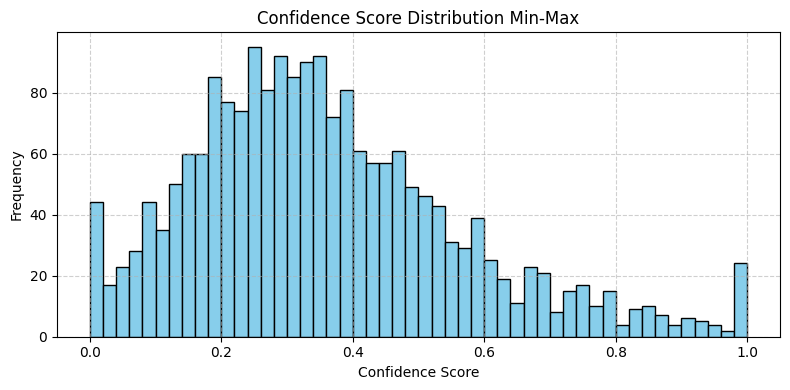

In [30]:
# Plot a histogram to visualize distribution
plt.figure(figsize=(8, 4))
plt.hist(normalized_confidence_robust, bins=50, color='skyblue', edgecolor='black')
plt.title("Confidence Score Distribution Min-Max")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Evaluate recommendation threshold

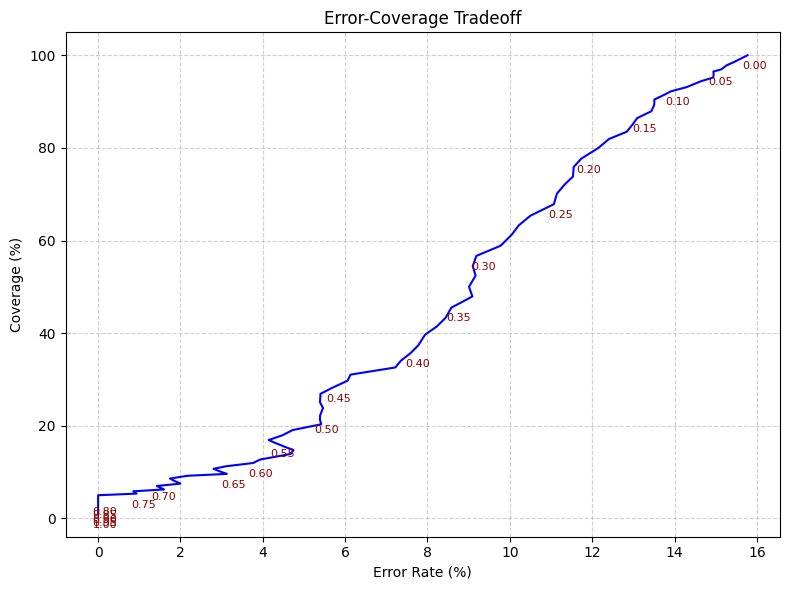

In [28]:
# The data we use
normalized_confidence_robust = normalized_confidence_robust.copy()
correct_recommendation_mask = correct_recommendation_mask.copy()

# Track error and coverage rates
error_rates = []
coverage_rates = []

# Loop over thresholds (0, 1 with steps of 0.01 exactly)
for th in np.linspace(0,1,101):

  # Find recommendations above threshold
  recommendations_shown_mask = normalized_confidence_robust >= th
  total_shown = np.sum(recommendations_shown_mask)
  #print(total_shown)

  # Both 0 if non shown
  if total_shown == 0:
    coverage, error_rate = 0, 0
  else:
    # Else calculate coverage and error rate
    # Our recommendations_shown_mask shows us which ones are shown
    # While our correct_recommendation_mask tells us which ones should have been shown
    # Calculate which ones that are shown are correct
    correct_shown = correct_recommendation_mask[recommendations_shown_mask]
    # % incorrectly shown
    error_rate = ((1 - correct_shown.mean())) * 100
    # % of recommendations that we would like to be shown to the user
    coverage = (total_shown / len(correct_recommendation_mask)) * 100

    error_rates.append(error_rate)
    coverage_rates.append(coverage)

thresholds = np.linspace(0,1,101)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(error_rates, coverage_rates, color='blue')

# Annotate every N-th threshold for readability
for i in range(0, len(thresholds), 5):
    plt.annotate(f"{thresholds[i]:.2f}",
                 (error_rates[i], coverage_rates[i]),
                 textcoords="offset points", xytext=(5, -10),
                 ha='center', fontsize=8, color='darkred')

plt.xlabel('Error Rate (%)')
plt.ylabel('Coverage (%)')
plt.title('Error-Coverage Tradeoff')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [29]:
result = [
    (float(t), round(float(e),3), round(float(c), 3))
    for t, e, c in zip(thresholds, error_rates, coverage_rates)
]

result

[(0.0, 15.774, 100.0),
 (0.01, 15.447, 98.548),
 (0.02, 15.259, 97.797),
 (0.03, 15.211, 97.446),
 (0.04, 15.134, 96.945),
 (0.05, 14.946, 96.495),
 (0.06, 14.95, 95.794),
 (0.07, 14.94, 95.193),
 (0.08, 14.642, 94.392),
 (0.09, 14.301, 93.14),
 (0.1, 13.905, 92.188),
 (0.11, 13.778, 91.587),
 (0.12, 13.511, 90.436),
 (0.13, 13.509, 89.334),
 (0.14, 13.44, 87.932),
 (0.15, 13.094, 86.43),
 (0.16, 12.972, 84.927),
 (0.17, 12.837, 83.475),
 (0.18, 12.408, 81.923),
 (0.19, 12.148, 79.97),
 (0.2, 11.734, 77.666),
 (0.21, 11.551, 75.864),
 (0.22, 11.533, 73.811),
 (0.23, 11.327, 72.058),
 (0.24, 11.143, 70.105),
 (0.25, 11.07, 67.852),
 (0.26, 10.498, 65.348),
 (0.27, 10.214, 63.245),
 (0.28, 10.049, 61.292),
 (0.29, 9.779, 58.888),
 (0.3, 9.187, 56.685),
 (0.31, 9.099, 54.482),
 (0.32, 9.169, 52.429),
 (0.33, 9.009, 50.025),
 (0.34, 9.091, 47.922),
 (0.35000000000000003, 8.581, 45.518),
 (0.36, 8.439, 43.315),
 (0.37, 8.222, 41.412),
 (0.38, 7.945, 39.71),
 (0.39, 7.775, 37.356),
 (0.4, 7.

## Task 4

### Step 1: Visualize the feature landscape

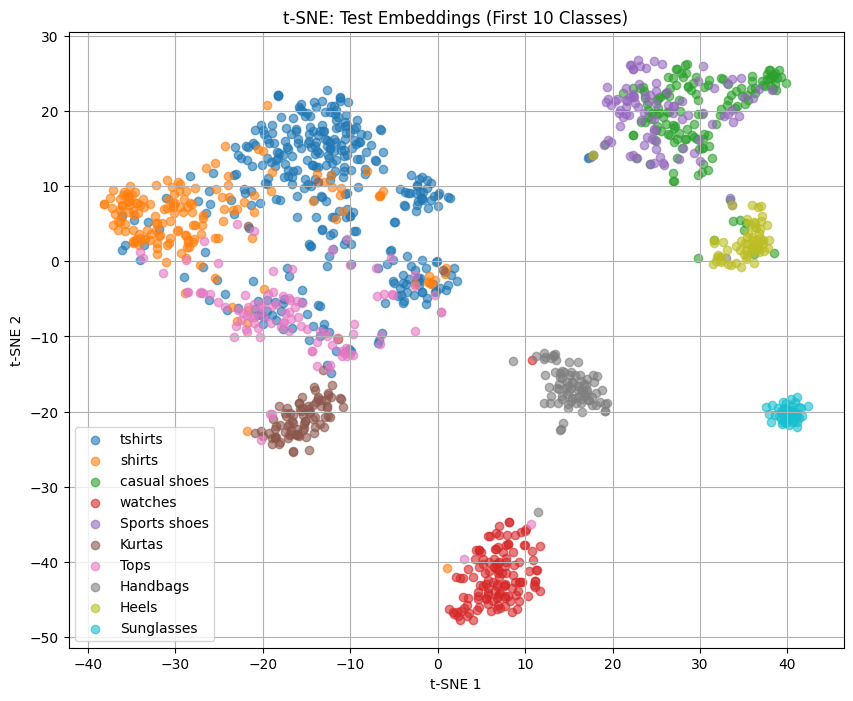

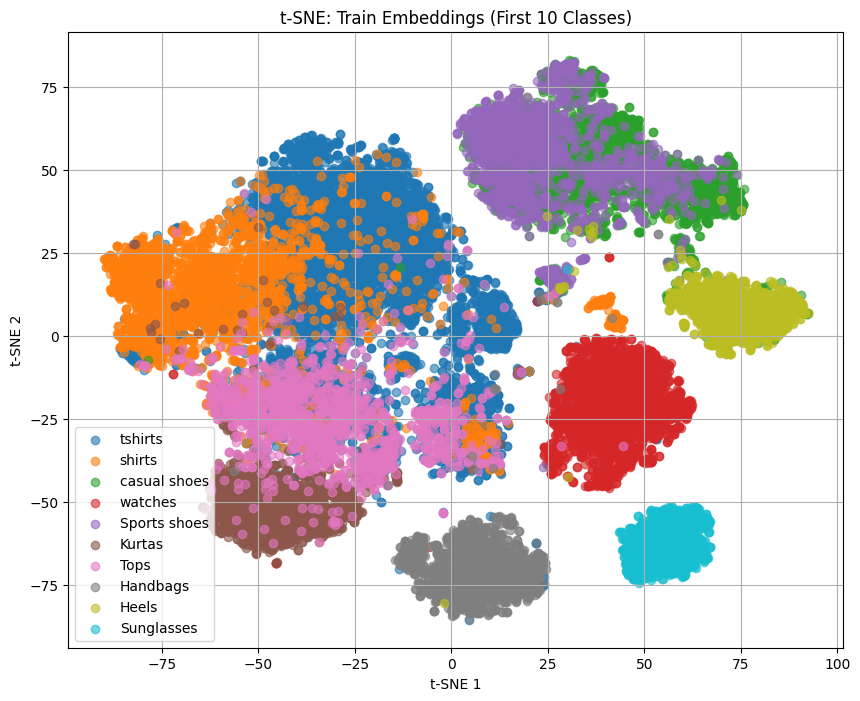

In [28]:
#Load the model of the main classes train and main classes test datasets

train_embeddings = np.load('train_embeddings.npy')
train_labels = np.load('train_labels.npy')
test_embeddings = np.load('test_embeddings.npy')
test_labels = np.load('test_labels.npy')

test_labels = test_labels.ravel()
train_labels = train_labels.ravel()

selected_classes = np.unique(train_labels)[:10]
test_mask = np.isin(test_labels, selected_classes)

test_emb_selected = test_embeddings[test_mask]
test_labels_selected = test_labels[test_mask]

class_names = {
    0: 'tshirts', 1: 'shirts', 2: 'casual shoes', 3: 'watches', 4: 'Sports shoes',
    5: 'Kurtas', 6: 'Tops', 7: 'Handbags', 8: 'Heels', 9: 'Sunglasses'
}

tsne = TSNE(n_components=2,random_state=42)
test_emb_2d = tsne.fit_transform(test_emb_selected)

def plot_tsne(embeddings_2d, labels, title, label_map=None):
    plt.figure(figsize=(10, 8))
    for class_id in np.unique(labels):
        idx = labels == class_id
        label_name = label_map[class_id] if label_map else f'Class {class_id}'
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=label_name, alpha=0.6)
    plt.legend()
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()

plot_tsne(test_emb_2d, test_labels_selected, "t-SNE: Test Embeddings (First 10 Classes)", class_names)

train_mask = np.isin(train_labels, selected_classes)
train_emb_selected = train_embeddings[train_mask]
train_labels_selected = train_labels[train_mask]

train_emb_2d = tsne.fit_transform(train_emb_selected)
plot_tsne(train_emb_2d, train_labels_selected, "t-SNE: Train Embeddings (First 10 Classes)", class_names)




### Step 2: Verifying assumptions with confusion matrix

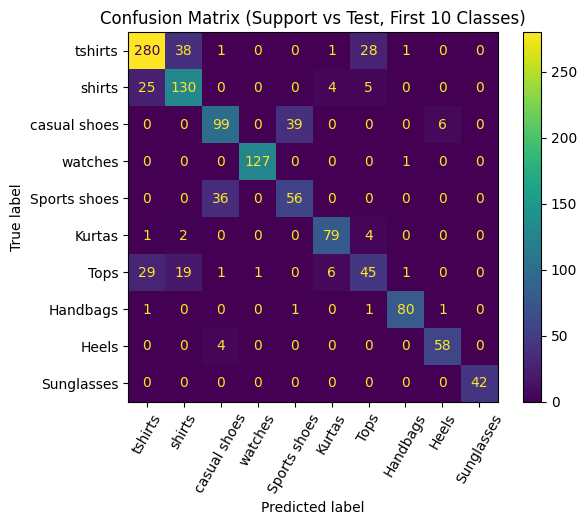

In [29]:
#load the model of the support and test datasets

support_embeddings = np.load('support_embeddings.npy')
support_labels = np.load('support_labels.npy').ravel()

test_embeddings = np.load('test_embeddings.npy')
test_labels = np.load('test_labels.npy').ravel()

# Keep only first 10 classes
selected_classes = np.unique(support_labels)[:10]
support_mask = np.isin(support_labels, selected_classes)
test_mask = np.isin(test_labels, selected_classes)

support_embeddings = support_embeddings[support_mask]
support_labels = support_labels[support_mask]
test_embeddings = test_embeddings[test_mask]
test_labels = test_labels[test_mask]

#Use cosine similarity to find the nearest neighbors between the support and test embeddings
similarity = cosine_similarity(test_embeddings, support_embeddings)

#each test sample, the most similar support sample
nearest_indices = np.argmax(similarity, axis=1)
predicted_labels = support_labels[nearest_indices]

#Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels, labels=selected_classes)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names.values())
disp.plot(xticks_rotation=60,cmap='viridis')
plt.title("Confusion Matrix (Support vs Test, First 10 Classes)")
plt.show()


### Step 3: A closer look at shirtts vs T-shirts


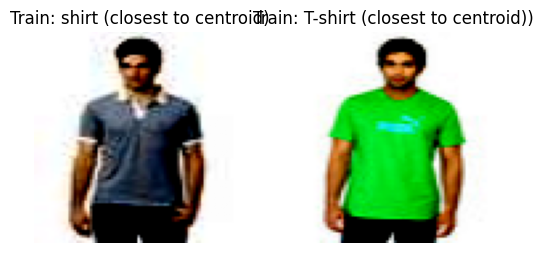

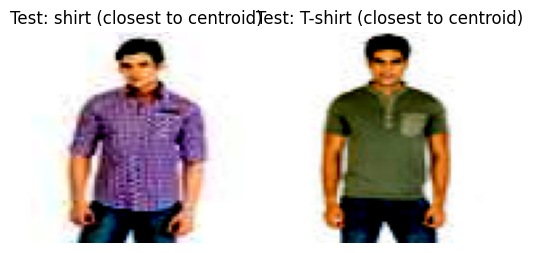

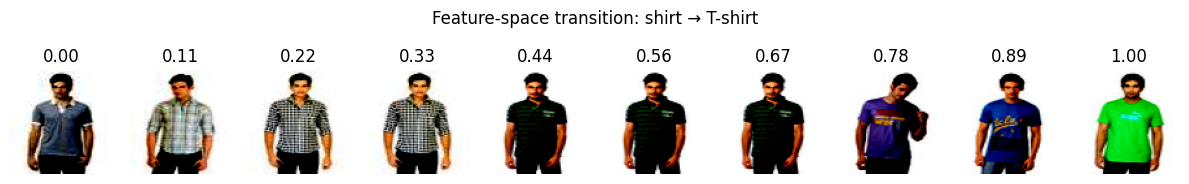

In [30]:
# class IDs for shirt vs t-shirt
SHIRT_CL   = 1
TSHIRT_CL  = 0

# Load embeddings and labels from repository
train_features = np.load('train_embeddings.npy')
train_labels = np.load('train_labels.npy')
train_imgs = np.load('train_images.npy')

test_features = np.load('test_embeddings.npy')
test_labels = np.load('test_labels.npy')
test_imgs = np.load('test_images.npy')


def compute_centroid(features, labels, cid):
    """Mean feature vector for class cid."""
    idx = np.where(labels == cid)[0]
    return features[idx].mean(axis=0)

# train centroids
centroid_train_shirt  = compute_centroid(train_features, train_labels, SHIRT_CL)
centroid_train_tshirt = compute_centroid(train_features, train_labels, TSHIRT_CL)

# test centroids
centroid_test_shirt  = compute_centroid(test_features, test_labels, SHIRT_CL)
centroid_test_tshirt = compute_centroid(test_features, test_labels, TSHIRT_CL)


#  Find images nearest to centroid

def find_nearest(features, imgs, centroid):
    dists = np.linalg.norm(features - centroid[None,:], axis=1)
    idx0  = np.argmin(dists)
    return imgs[idx0], dists[idx0]

# Get typical shirt/t-shirt from train
img_train_shirt,  _ = find_nearest(train_features, train_imgs, centroid_train_shirt)
img_train_tshirt, _ = find_nearest(train_features, train_imgs, centroid_train_tshirt)

img_test_shirt,  _ = find_nearest(test_features, test_imgs, centroid_test_shirt)
img_test_tshirt, _ = find_nearest(test_features, test_imgs, centroid_test_tshirt)

# Plot them side by side
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_train_shirt);  plt.axis('off'); plt.title('Train: shirt (closest to centroid)')
plt.subplot(1,2,2)
plt.imshow(img_train_tshirt); plt.axis('off'); plt.title('Train: T-shirt (closest to centroid))')
plt.show()

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img_test_shirt);  plt.axis('off'); plt.title('Test: shirt (closest to centroid)')
plt.subplot(1,2,2)
plt.imshow(img_test_tshirt); plt.axis('off'); plt.title('Test: T-shirt (closest to centroid)')
plt.show()


# Transition along the line between centroids

# choose number of interpolation steps
n_steps = 10
ts = np.linspace(0, 1, n_steps)

# for each t, form the interpolated point and find nearest neighbor in train set
transition_imgs = []
for t in ts:
    interp = (1-t)*centroid_train_shirt + t*centroid_train_tshirt
    img, dist = find_nearest(train_features, train_imgs, interp)
    transition_imgs.append(img)

# make a transition from shirts to tshirts
plt.figure(figsize=(12, 2))
for i, img in enumerate(transition_imgs):
    plt.subplot(1, n_steps, i+1)
    plt.imshow(img); plt.axis('off')
    plt.title(f"{ts[i]:.2f}")
plt.suptitle("Feature‐space transition: shirt → T-shirt")
plt.tight_layout()
plt.show()


### Step 4: Representation of Higher Level Classes

In [31]:
# Select device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Initialize model
embedding_net = EmbeddingNet()
model = embedding_net.to(device)

# Load the model's state dictionary
model.load_state_dict(torch.load('models/embedding_model.pth', map_location=device))

batch_size = 128
support_loader = DataLoader(main_support_dataset_cat, batch_size=batch_size, shuffle=False)
test_loader    = DataLoader(main_test_dataset_cat,    batch_size=batch_size, shuffle=False)

support_feats, support_cats, _ = extract_embeddings(support_loader, model)
test_feats,    test_cats, _    = extract_embeddings(test_loader, model)

# Fit 1-NN on support set
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(support_feats)

# find nearest neighbor
dists, idxs = nn.kneighbors(test_feats, return_distance=True)
pred_cats    = support_cats[idxs.squeeze()]

acc     = accuracy_score(test_cats, pred_cats)
bal_acc = balanced_accuracy_score(test_cats, pred_cats)

print("High‐level category classification (Scenario 2)")
print(f"  Overall accuracy          : {acc*100:.2f}%")
print(f"  Balanced accuracy         : {bal_acc*100:.2f}%")

High‐level category classification (Scenario 2)
  Overall accuracy          : 94.19%
  Balanced accuracy         : 90.76%
